## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

#!pip  install subword-nmt
#!pip install nltk
#!pip install torchtext

In [7]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [9]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [10]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)],
)

In [11]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [12]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [13]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [14]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9284
Unique tokens in target (en) vocabulary: 6667


Here are tokens from original (RU) corpus:

In [15]:
SRC.vocab.itos[::1000]

['<unk>',
 'стадион',
 'варны',
 'настольного',
 'gallery',
 'alpenhof',
 'nina',
 'фонтаном',
 'джексон',
 'сяошань']

And from target (EN) corpus:

In [16]:
type(TRG)

torchtext.data.field.Field

In [17]:
TRG.vocab.itos[::1000]

['<unk>', 'subway', 'elena', 'citizens', 'mega', 'smaller', 'merino']

And here is example from train dataset:

In [18]:
print(vars(train_data.examples[9]))

{'trg': ['offering', 'air', '-', 'conditioned', 'suites', ',', 'seorak', 'kumho', 'resort', 'features', 'a', 'restaurant', ',', 'fitness', 'centre', ',', 'and', '24', '-', 'hour', 'front', 'desk', 'in', 'peaceful', 'mountains', '5', 'km', 'from', 'sokcho', '’', 's', 'centre', '.'], 'src': ['курортный', 'отель', 'seorak', 'kumho', 'находится', 'среди', 'тихих', 'гор', ',', 'в', '5', 'км', 'от', 'центра', 'города', 'сокчхо', '.', 'к', 'услугам', 'гостей', 'люксы', 'с', 'кондиционером', ',', 'ресторан', ',', 'фитнес', '-', 'центр', 'и', 'круглосуточная', 'стойка', 'регистрации', '.']}


Let's check the length distributions:

Length distribution in Train data


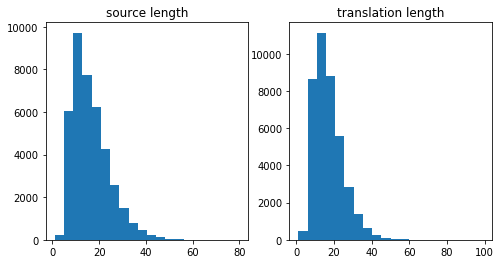

In [19]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


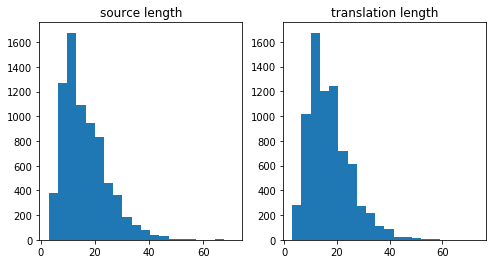

In [20]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
device

device(type='cpu')

In [33]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [34]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 67x128]
	[.src]:[torch.LongTensor of size 43x128]
torch.Size([43, 128]) torch.Size([67, 128])


In [25]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

TypeError: __init__() missing 2 required positional arguments: 'dropout' and 'device'

In [21]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9229, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6697, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6697, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

NameError: name 'model' is not defined

In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [145]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

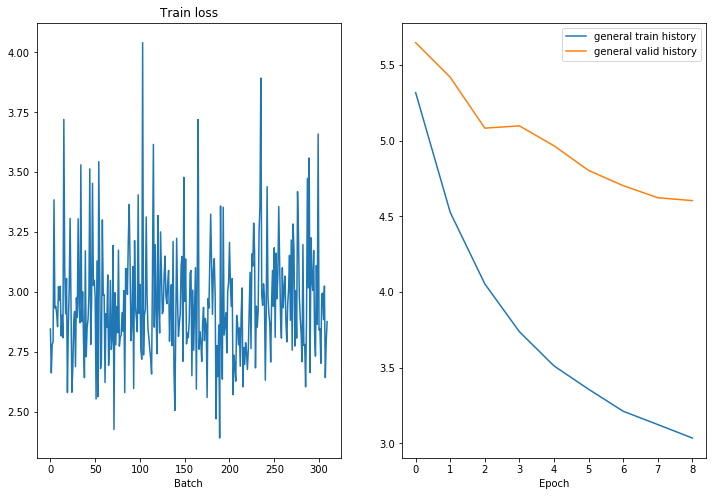

epoch 9, time: 72 min 53 sec
Epoch: 10 | Time: 72m 53s
	Train Loss: 2.957 | Train PPL:  19.244
	 Val. Loss: 4.599 |  Val. PPL:  99.338


In [29]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/model-n0.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
#del utils

NameError: name 'utils' is not defined

In [28]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [29]:
batch = next(iter(test_iterator))

In [30]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: front desk is 24 hours a day .
Generated: rental dewi transfers mixed 350 transfers stresa stresa transfers transfers minsk transfers madina madina

Original: free private parking is also available at this apartment .
Generated: rental dewi mixed transfers 350 350 transfers transfers stresa madina madina transfers madina madina



In [31]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [32]:
import tqdm

In [36]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:50,  1.16it/s]


In [37]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.147439539896004

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

# LSTM

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
PAD_IDX = TRG.vocab.stoi['<pad>']

optimizer = optim.AdamW(model.parameters())
# optimizer = optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters())

#criterion = nn.AdaptiveLogSoftmaxWithLoss()
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.002, max_lr=0.02, step_size_up=1000)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'avg')
scheduler = None

train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 1

best_valid_loss = float('inf')

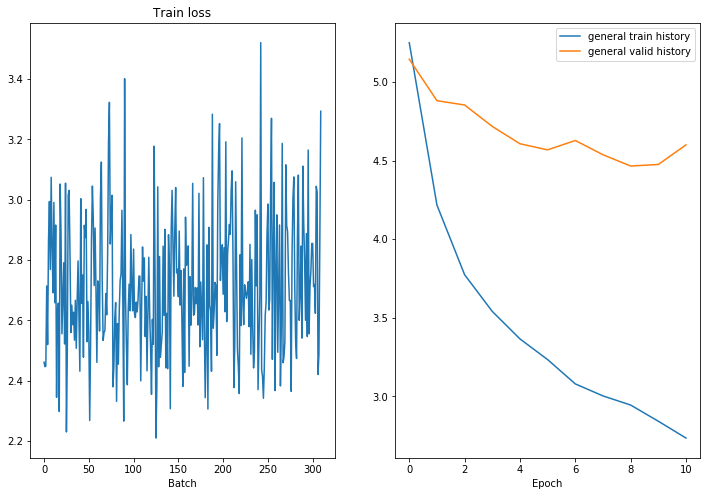

Epoch: 12 | Time: 84m 26s
	Train Loss: 2.716 | Train PPL:  15.115
	 Val. Loss: 4.449 |  Val. PPL:  85.506


In [34]:
model.train()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    if scheduler:
        scheduler.step(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/models-n1.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [35]:
def get_score(model):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
    print("bleu score: {}".format(bleu_score))

In [36]:
get_score(model)

59it [01:54,  1.94s/it]


bleu score: 17.760983070850315


In [37]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: front desk is 24 hours a day .
Generated: there is a 24 - hour front desk .

Original: free private parking is also available at this apartment .
Generated: private parking is available on site .



Просто чуть-чуть настроили гиперпараметры исходной модели, добавив всего 2 пункта к bleu. Тут очень мало изменений, однако я сильно опоздал со сдачей(

# CNN+CNN

In [188]:
#del cnn_network

In [189]:
import cnn_network_v5 as cnn_network

In [204]:
BATCH_SIZE = 128

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key = _len_sort_key,
    sort_within_batch=True
)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9284
Unique tokens in target (en) vocabulary: 6667
cpu


In [205]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
MAX_LEN = 100

EMB_DIM = 256
HID_DIM = 512

ENC_LAYERS = 4
DEC_LAYERS = 4

ENC_KERNEL_SIZE = 3 
DEC_KERNEL_SIZE = 3

ENC_DROPOUT = 0.1 #0.25 
DEC_DROPOUT = 0.1 #0.25

encoder = cnn_network.Encoder(
    INPUT_DIM, 
    EMB_DIM, 
    HID_DIM, 
    ENC_LAYERS, 
    ENC_KERNEL_SIZE, 
    MAX_LEN, 
    ENC_DROPOUT, 
    device
)
decoder = cnn_network.Decoder(
    OUTPUT_DIM, 
    EMB_DIM, 
    HID_DIM, 
    DEC_LAYERS, 
    DEC_KERNEL_SIZE, 
    TRG_PAD_IDX,
    MAX_LEN, 
    DEC_DROPOUT, 
    device
)

model = cnn_network.Seq2Seq(encoder, decoder).to(device)

optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [206]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,227,915 trainable parameters


In [207]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9284, 256)
    (pos_embedding): Embedding(100, 256)
    (embedding_to_hidden_layer): Linear(in_features=256, out_features=512, bias=True)
    (hidden_to_embedding_layer): Linear(in_features=512, out_features=256, bias=True)
    (conv_layers): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6667, 256)
    (pos_embedding): Embedding(100, 256)
    (embedding_to_hidden_layer): Linear(in_features=256, out_features=512, bias=True)
    (hidden_to_embedding_layer): Linear(in_features=512, out_features=256, bias=True)
    (attn_hidden_to_embedding_layer): Linear(in_feature

In [208]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    # global PLOT_STEP
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)


def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

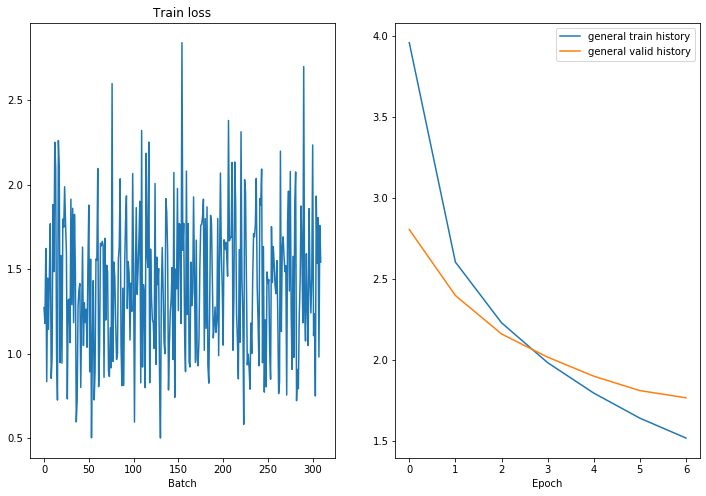

Epoch: 08 | Time: 27m 20s
	Train Loss: 1.407 | Train PPL:   4.085
	 Val. Loss: 1.723 |  Val. PPL:   5.603


In [209]:
# from IPython.display import clear_output
N_EPOCHS = 8
CLIP = 1

best_valid_loss = float('inf')
train_history=[]
valid_history=[]

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/cnn-model-n2.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    try:
        train_ppl = math.exp(train_loss)
    except OverflowError:
        train_ppl= float("inf")
        
    try:
        val_ppl = math.exp(valid_loss)
    except OverflowError:
        val_ppl = float("inf")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {val_ppl:7.3f}')

In [210]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_len = torch.LongTensor([len(src_indexes)]).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        #insert input token embedding, previous hidden state and all encoder hidden states
        #receive output tensor (predictions) and new hidden state
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for i, datum in enumerate(data):
      
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [210]:
src = ['кроме', 'того', ',', 'в', 'каждом', 'номере', 'имеется', 'душевая', 'комната', 'с', 'бесплатными', 'туалетно', '-', 'косметическими', 'принадлежностями', '.']
trg = ['the', 'en', 'suite', 'shower', 'rooms', 'have', 'complimentary', 'toiletries', '.']
translation = ['each', 'room', 'has', 'a', 'double', 'room', 'with', 'a', 'shower', 'and', 'free', 'toiletries', '.', '<eos>']

In [211]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f"src = {' '.join(src)}")
print(f"trg = {' '.join(trg)}")

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f"predicted trg = {' '.join(translation)}")

src = кроме того , в каждом номере имеется душевая комната с бесплатными туалетно - косметическими принадлежностями .
trg = the en suite shower rooms have complimentary toiletries .
predicted trg = each room has a double room with a shower and free toiletries . <eos>


In [212]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 27.96


CNN в энкодере + CNN с аттеншном в декодере. При обучении берта из пункта ниже ни разу не взрывались градиенты (большинство ошибок там было связано с тем, что модель "ничему не училась", генерируя белый шум, что, скорее всего, было связано с ошибками в реализациеи архитектуры из статьи), а тут же чаще всего сталкивался именно с этой проблемой. Впрочем, в итоге был получен неплохой результат.

# BERT

In [157]:
#del bert_network

In [158]:
import bert_network_v25 as bert_network

In [159]:
BATCH_SIZE = 128

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key = _len_sort_key,
    sort_within_batch=True
)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9284
Unique tokens in target (en) vocabulary: 6667
cpu


In [160]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256

ENC_MAX_LEN = 100

ENC_PF_DIM = 512
DEC_PF_DIM = 512

ENC_LAYERS = 3
DEC_LAYERS = 3

ENC_HEADS = 8
DEC_HEADS = 8

ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

LEARNING_RATE = 0.0005


enc = bert_network.Encoder(
    INPUT_DIM, 
    HID_DIM, 
    ENC_PF_DIM, 
    ENC_LAYERS, 
    ENC_HEADS, 
    ENC_MAX_LEN,
    ENC_DROPOUT, 
    device
)

dec = bert_network.Decoder(
    OUTPUT_DIM, 
    HID_DIM, 
    DEC_PF_DIM, 
    DEC_LAYERS, 
    DEC_HEADS, 
    ENC_MAX_LEN,
    DEC_DROPOUT, 
    device
)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = bert_network.Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [161]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1) % 10 ==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)


def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [162]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (token_embedding): Embedding(9284, 256)
    (position_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention_layer): MultiHeadAttentionLayer(
          (queries_layer): Linear(in_features=256, out_features=256, bias=True)
          (keys_layer): Linear(in_features=256, out_features=256, bias=True)
          (values_layer): Linear(in_features=256, out_features=256, bias=True)
          (outputs_layer): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attention_norm_layer): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward_layer): PositionwiseFeedforwardLayer(
          (feed_forward_in_layer): Linear(in_features=256, out_features=512, bias=True)
          (feed_forward_out_layer): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_f

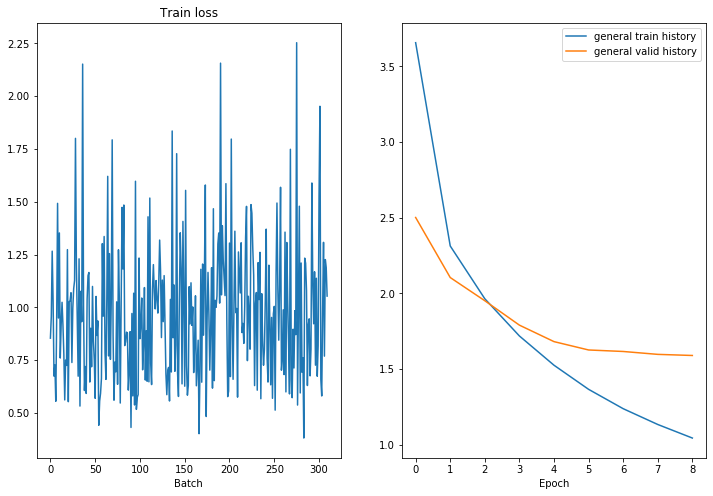

Epoch: 10 | Time: 17m 32s
	Train Loss: 0.969 | Train PPL:   2.635
	 Val. Loss: 1.608 |  Val. PPL:   4.991


In [163]:
N_EPOCHS = 10
CLIP = 1

train_attention = train_cnn
evaluate_attention = evaluate_cnn

best_valid_loss = float('inf')
train_history=[]
valid_history=[]

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_attention(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_attention(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/bert-model-n3.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    

In [164]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.get_src_vector_mask(src_tensor)

    with torch.no_grad():
        # enc_src = [batch_sz, src_len, hid_dim]
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.get_trg_vector_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention


from torchtext.data.metrics import bleu_score

def calculate_bleu(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)

In [165]:
bleu_score = calculate_bleu(test_iterator, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score[2]*100:.2f}')

BLEU score = 30.18


Данный трансформер повторяет архитектуру из статьи "Attention is All You Need", и при этом показал хороший результат! Думаю, можно было выжать еще больше, настроив гиперпараметры более удачным образом.